# Predicting electricity production
by Christoph Stich

March 2, 2016

**Disclaimer: ** I couldn't help but look at the other submissions and find out about their score. However, I do significantly outperform all submissions I have looked at and think that I bring enough of my own ideas into this to be a worthwile submission.

In [1]:
from sklearn import ensemble 
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn import utils

import copy
import csv
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.asarray(y_true)
    y_test = np.asarray(y_true)

    # y_true, y_pred = utils.check_array(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def normalize(x):
    return math.sqrt(x**2)

/home/christoph/anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Exploring the data

In [2]:
df_train = pd.read_csv('../../data/training_dataset_500.csv')
df_test = pd.read_csv('../../data/test_dataset_500.csv')

In [3]:
df_train.head(5)

,ID,Label,House,Year,Month,Temperature,Daylight,EnergyProduction
0,0,0,1,2011,7,26.2,178.9,740
1,1,1,1,2011,8,25.8,169.7,731
2,2,2,1,2011,9,22.8,170.2,694
3,3,3,1,2011,10,16.4,169.1,688
4,4,4,1,2011,11,11.4,169.1,650


In [4]:
df_test.head(5)

,ID,Label,House,Year,Month,Temperature,Daylight,EnergyProduction
0,23,23,1,2013,6,22.0,125.5,778
1,47,23,2,2013,6,21.1,123.1,627
2,71,23,3,2013,6,21.9,126.8,735
3,95,23,4,2013,6,20.2,125.2,533
4,119,23,5,2013,6,20.2,125.2,533


In [5]:
# Check for duplicates
df_dup = df_train.loc[0:,'House':]
df_dup['Daylight'] = df_dup['Daylight'] * 10
df_dup['Temperature'] = df_dup['Temperature'] * 10
unique = set([tuple(row for row in d) for d in df_dup.values.astype(int)])
print('# total obs.: ', len(df_dup), ', # unique obs.: ', len(unique))
# Check for NA in the data
print('Any NA: ', df_train.isnull().values.any())

# total obs.:  11500 , # unique obs.:  11500
Any NA:  False


I can see that there are not duplicate values in the dataset nor are there any values missing.

### Correlations before transformation

In [6]:
df_train[['Month', 'Temperature','Daylight','EnergyProduction']].corr()

,Month,Temperature,Daylight,EnergyProduction
Month,1.000000,0.353837,-0.276307,-0.232748
Temperature,0.353837,1.000000,-0.053363,0.272789
Daylight,-0.276307,-0.053363,1.000000,0.531577
EnergyProduction,-0.232748,0.272789,0.531577,1.000000


### Correlations after transformation

In [7]:
df_train['Month'] = np.sqrt((df_train['Month']-6)**2)
df_test['Month'] = np.sqrt((df_test['Month']-6)**2)
df_train[['Month', 'Temperature','Daylight','EnergyProduction']].corr()

,Month,Temperature,Daylight,EnergyProduction
Month,1.000000,-0.707952,-0.057621,-0.442437
Temperature,-0.707952,1.000000,-0.053363,0.272789
Daylight,-0.057621,-0.053363,1.000000,0.531577
EnergyProduction,-0.442437,0.272789,0.531577,1.000000


I can transform the relatinoship between energy production and month into a linear relationship by applying sqrt((month-x)\*\*2). I tried several values for x and found that 6 increases the correlation the most.

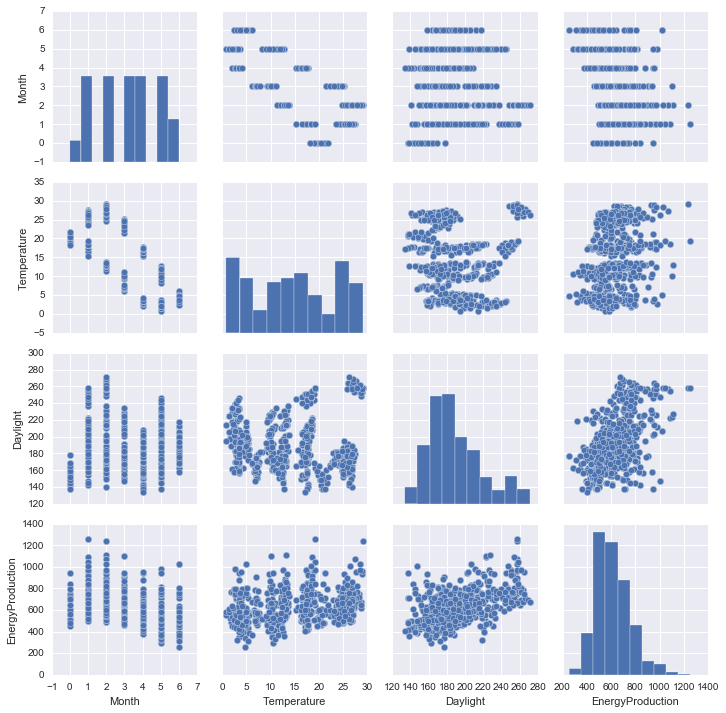

In [8]:
g = sns.PairGrid(df_train[['Month', 'Temperature','Daylight','EnergyProduction']])
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)
g = g.map_diag(plt.hist, edgecolor="w")

When looking at the different scatter plots and at the relationship between energy consumption and the other variables, I can see that month, temperature, and daylight exhibit a somewhat linear relationship with energy production.

## Building a model

In [9]:
X_train = df_train.loc[0:, 'House':'Daylight'].values
y_train = df_train.loc[0:, 'EnergyProduction'].values
X_test = df_test.loc[0:, 'House':'Daylight'].values
y_test = df_test.loc[0:, 'EnergyProduction'].values

### First models
We are going to start by building a simple multiple regression model and a general linear model. Statsmodels formula API allows us to specify models in R notation.

In [ ]:
lrg = smf.ols('EnergyProduction ~ Temperature + Daylight + Month + C(House)', df_train).fit()
print("Linear regression MAPE: ", mean_absolute_percentage_error(y_test, lrg.predict(df_test)))

Linear regression MAPE:  5.54876527488


In [ ]:
glm = smf.glm('EnergyProduction ~ Temperature + Daylight + Month + C(House)', df_train).fit()
print("GLM MAPE: ", mean_absolute_percentage_error(y_test, glm.predict(df_test)))

Both models perform quite well already. Let us see how a random forest regressor and an adaboost regressor perform.

In [ ]:
rfr = ensemble.RandomForestRegressor(n_estimators=500, max_features='sqrt')
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print('RFR MAPE: ', mean_absolute_percentage_error(y_test, y_pred))

In [ ]:
abr = ensemble.AdaBoostRegressor(n_estimators=500)
abr.fit(X_train, y_train)
y_pred = abr.predict(X_test)
print('ABR MAPE: ', mean_absolute_percentage_error(y_test, y_pred))

That is surprisingly a lot worse than both the linear models.

In [ ]:
svr_rbf = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = svm.SVR(kernel='linear', C=1e3)
# svr_poly = svm.SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)
y_lin = svr_lin.fit(X_train, y_train).predict(X_test)
# y_poly = svr_poly.fit(X_train, y_train).predict(X_test) # This takes really long, thus I skipped it
print('SVR Rbf MAPE: ', mean_absolute_percentage_error(y_rbf, y_pred))
print('SVR linear MAPE: ', mean_absolute_percentage_error(y_lin, y_pred))
# print('SVR polynomial MAPE: ', mean_absolute_percentage_error(y_poly, y_pred))

Also the SVM regressor is performing worse than the linear models, but a lot better than the random forest or the ada boost regressor. What is going on?

### Why doe the linear model work so well?

In [ ]:
glm.summary()

My hunch is that the more complicated models perform worse, because the linear models deal with categorical data differently. The linear models give each house its own coefficient. Intuitively this should account for the "baseline" production rate of each house.

In [ ]:
glm = smf.glm('EnergyProduction ~ Temperature + Daylight + Month', df_train).fit()
print("GLM MAPE: ", mean_absolute_percentage_error(y_test, glm.predict(df_test)))

And indeed removing the houses from the general linear model as an independent variable, decreases performance quite dramatically. One idea is construct the baseline production rate for each house as an additional feature and create a feature that measures in standard deviations how much each value for production differs from the mean (the baseline).

In [ ]:
baseline = df_train.groupby('House')['EnergyProduction'].mean()
baseline_std = df_train.groupby('House')['EnergyProduction'].std()
df_train = df_train.join(baseline, on='House', rsuffix='_baseline')
df_train = df_train.join(baseline_std, on='House', rsuffix='_std')
df_train['E-zscore'] = (df_train['EnergyProduction'] - df_train['EnergyProduction_baseline'])/df_train['EnergyProduction_std']
df_train.drop(['EnergyProduction_baseline', 'EnergyProduction_baseline'], 1)

lookup_base = dict(zip(baseline.index, baseline))
lookup_std = dict(zip(baseline_std.index, baseline_std))
df_test['EnergyProduction_baseline'] = [lookup_base[key] for key in df_test['House'].values]
df_test['EnergyProduction_std'] = [lookup_std[key] for key in df_test['House'].values]
df_test['E-zscore'] = (df_test['EnergyProduction'] - df_test['EnergyProduction_baseline'])/df_test['EnergyProduction_std']
df_test.drop(['EnergyProduction_baseline', 'EnergyProduction_baseline'], 1)

In [ ]:
sns.regplot(x='EnergyProduction_baseline', y='EnergyProduction', data=df_train)

There is unsurprisingly a strong correlation between the energy production and the baseline production of each house. Let's try out our new feature.

In [ ]:
X_train = df_train.loc[0:, 'House':'E-zscore'].values
y_train = df_train.loc[0:, 'EnergyProduction'].values
X_test = df_test.loc[0:, 'House':'E-zscore'].values
y_test = df_test.loc[0:, 'EnergyProduction'].values

In [ ]:
rfr = ensemble.RandomForestRegressor(n_estimators=500, max_features='sqrt')
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print('RFR MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
final_y_test = copy.copy(y_test)
final_y_pred = copy.copy(y_pred)

In [ ]:
abr = ensemble.AdaBoostRegressor(n_estimators=500)
abr.fit(X_train, y_train)
y_pred = abr.predict(X_test)
print('ABR MAPE: ', mean_absolute_percentage_error(y_test, y_pred))

In [ ]:
svr_rbf = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = svm.SVR(kernel='linear', C=1e3)
# svr_poly = svm.SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)
y_lin = svr_lin.fit(X_train, y_train).predict(X_test)
# y_poly = svr_poly.fit(X_train, y_train).predict(X_test) # This takes really long, thus I skipped it
print('SVR Rbf MAPE: ', mean_absolute_percentage_error(y_rbf, y_pred))
print('SVR linear MAPE: ', mean_absolute_percentage_error(y_lin, y_pred))
# print('SVR polynomial MAPE: ', mean_absolute_percentage_error(y_poly, y_pred))

0.9 is already pretty good for the random forest regressor and a huge increase. Let's see whether we can get any better. One idea I have is to build seperate models for each house as the baseline production rate for each house seems to be very important for each house. While in this way I can fit each model to the individual dynamics of production for each house, the downside is that we are having fewer datapoints to train on for each house.

### Individual "house" models

In [ ]:
# Build a seperate model for each house
houses_train = df_train.loc[0:, 'House':].groupby('House').groups
houses_test = df_test.loc[0:, 'House':].groupby('House').groups
houses = list(set(houses_train.keys()) & set(houses_test.keys()))

In [ ]:
# House RFR
y_true = list()
y_pred = list()
y_pred_glm = list()
for house in houses:
    rows_train = houses_train[house]
    rows_test = houses_test[house]
    rfr = ensemble.RandomForestRegressor(n_estimators=300)
    X_train = df_train.loc[rows_train, 'Month':]
    y_train = df_train.loc[rows_train, 'EnergyProduction'].values
    X_test = df_test.loc[rows_test, 'Month':]
    y_test = df_test.loc[rows_test, 'EnergyProduction'].values
    rfr.fit(X_train, y_train)
    y_true.append(y_test)
    y_pred.append(rfr.predict(X_test))
    
print('House RFR MAPE: ', mean_absolute_percentage_error(y_true, y_pred))

In [ ]:
# House AdaBoostRegressor
y_true = list()
y_pred = list()
y_pred_glm = list()
for house in houses:
    rows_train = houses_train[house]
    rows_test = houses_test[house]
    abr = ensemble.AdaBoostRegressor(n_estimators=500)
    X_train = df_train.loc[rows_train, 'Month':]
    y_train = df_train.loc[rows_train, 'EnergyProduction'].values
    X_test = df_test.loc[rows_test, 'Month':]
    y_test = df_test.loc[rows_test, 'EnergyProduction'].values
    abr.fit(X_train, y_train)
    y_true.append(y_test)
    y_pred.append(abr.predict(X_test))
    
print('House ABR MAPE: ', mean_absolute_percentage_error(y_true, y_pred))

In [ ]:
# House SVR
y_true = list()
y_pred = list()
y_pred_glm = list()
for house in houses:
    rows_train = houses_train[house]
    rows_test = houses_test[house]
    svr = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
    X_train = df_train.loc[rows_train, 'Month':]
    y_train = df_train.loc[rows_train, 'EnergyProduction'].values
    X_test = df_test.loc[rows_test, 'Month':]
    y_test = df_test.loc[rows_test, 'EnergyProduction'].values
    svr.fit(X_train, y_train)
    y_true.append(y_test)
    y_pred.append(rfr.predict(X_test))
    
print('House SVR MAPE: ', mean_absolute_percentage_error(y_true, y_pred))

In [ ]:
# House GLM
y_true = list()
y_pred = list()
for house in houses:
    rows_train = houses_train[house]
    rows_test = houses_test[house]
    X_train = df_train.loc[rows_train, 'Month':]
    X_test = df_test.loc[rows_test, 'Month':'Daylight']
    y_test = df_test.loc[rows_test, 'EnergyProduction'].values
    glm = smf.glm('EnergyProduction ~ Temperature + Daylight + Month', X_train).fit()
    y_true.append(y_test)
    y_pred.append(glm.predict(X_test))
    
print('MAPE: ', mean_absolute_percentage_error(y_true, y_pred))

In short, it doesn't really make sense to construct an indvidual model for each houes. The performance, while often not terrible, is throughout the bank worse.

### Findings

The best model for predicting is the random forest regressor with a MAPE of under 1%. Let's look how those predictions actually look like.

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8.75))
y = final_y_test
x = final_y_pred
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
plt.title('RFR predictions')
plt.xlabel('predictions')
plt.ylabel('true value')

## What to do next
1. One could start and fine tune the features and the parameters of the random forest regressor more. Scaling, normalization, and maybe some more transformations might further increase performance
2. If one could gather more data, I think it might be worthwhile to further explore the "indivdual" house models. I know it sounds trite, but we need more data.

In [ ]:
with open('predicted_energy_production.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['House', 'EnergyProduction'])
    for r, s in zip(list(df_test['House']), final_y_pred):
        w.writerow([r, s])